In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from adjustText import adjust_text
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.graph_objects as go
import us
!pip install -U kaleido


In [4]:
# Load data
data = pd.read_csv("ACLED-United_States.csv")
data.head()


event_id_cnty event_date  year  time_precision   disorder_type event_type  \
0      USA75198  13-Dec-24  2024               1  Demonstrations   Protests   
1      USA75220  13-Dec-24  2024               1  Demonstrations   Protests   
2      USA75226  13-Dec-24  2024               1  Demonstrations   Protests   
3      USA75234  13-Dec-24  2024               1  Demonstrations   Protests   
4      USA75238  13-Dec-24  2024               1  Demonstrations   Protests   

     sub_event_type                      actor1  \
0  Peaceful protest  Protesters (United States)   
1  Peaceful protest  Protesters (United States)   
2  Peaceful protest  Protesters (United States)   
3  Peaceful protest  Protesters (United States)   
4  Peaceful protest  Protesters (United States)   

                                       assoc_actor_1      inter1  ...  \
0  Health Workers (United States); Labor Group (U...  Protesters  ...   
1                              Women (United States)  Protesters  ...   
2  GOP: Republican Party; Government of the Unite...  Protesters  ...   
3  IBT: International Brotherhood of Teamsters; L...  Protesters  ...   
4                        Labor Group (United States)  Protesters  ...   

                   location latitude longitude geo_precision  \
0                  New Hope  45.0380  -93.3867             1   
1                  Hartford  41.7673  -72.6762             1   
2  New York - Staten Island  40.6058  -74.1350             1   
3                   Enfield  42.0002  -72.5947             1   
4                  Portland  43.6574  -70.2589             1   

                               source           source_scale  \
0  Channel 5 (Twin Cities); Instagram  New media-Subnational   
1                      WTNH Channel 8            Subnational   
2                     ABC7 (New York)            Subnational   
3                           Teamsters                  Other   
4                       CBS13 (Maine)            Subnational   

                                               notes fatalities  \
0  On 13 December 2024, SEIU Healthcare Minnesota...          0   
1  On 13 December 2024, protesters, victims' fami...          0   
2  On 13 December 2024, elected officials and sup...          0   
3  On 13 December 2024, 20 warehouse workers and ...          0   
4  On 13 December 2024, MaineHealth language inte...          0   

                   tags   timestamp  
0  crowd size=no report  1734479955  
1  crowd size=no report  1734479955  
2  crowd size=no report  1734479955  
3         crowd size=20  1734479955  
4  crowd size=no report  1734479956  

[5 rows x 31 columns]

## EVENT COUNTS

In [6]:
event_counts = data.groupby(['admin1', 'event_type']).size().unstack().fillna(0).astype(int)

event_counts.columns.name = None
event_counts = event_counts.reset_index()
if 'index' in event_counts.columns:
    event_counts = event_counts.drop(columns=['index'])
event_counts.rename(columns={'admin1': 'State'}, inplace=True)

event_counts

State  Battles  Explosions/Remote violence  Protests  \
0                Alabama        0                           0       622   
1                 Alaska        0                           0       143   
2                Arizona        1                           0       719   
3               Arkansas        0                           1       332   
4             California        1                           8      8543   
5               Colorado        1                           0       868   
6            Connecticut        0                           0      1108   
7               Delaware        0                           0       162   
8   District of Columbia        1                           0      1502   
9                Florida        0                           0      3003   
10               Georgia        0                           1      1224   
11                Hawaii        0                           0       371   
12                 Idaho        0                           0       300   
13              Illinois        0                           0      2448   
14               Indiana        0                           0       857   
15                  Iowa        0                           0       562   
16                Kansas        0                           0       322   
17              Kentucky        0                           0       663   
18             Louisiana        0                           0       620   
19                 Maine        0                           0       496   
20              Maryland        0                           0      1069   
21         Massachusetts        1                           0      2465   
22              Michigan        0                           0      1698   
23             Minnesota        1                           0      1336   
24           Mississippi        0                           0       362   
25              Missouri        2                           0       894   
26               Montana        0                           0       230   
27              Nebraska        0                           0       265   
28                Nevada        0                           0       480   
29         New Hampshire        0                           0       341   
30            New Jersey        0                           1      1083   
31            New Mexico        0                           0       416   
32              New York        2                           0      7168   
33        North Carolina        0                           2      1688   
34          North Dakota        0                           0       120   
35                  Ohio        2                           0      1563   
36              Oklahoma        0                           0       399   
37                Oregon        0                           0      1278   
38          Pennsylvania        3                           1      3074   
39          Rhode Island        0                           0       429   
40        South Carolina        0                           0       640   
41          South Dakota        0                           0       113   
42             Tennessee        0                           2      1022   
43                 Texas        3                           1      2141   
44                  Utah        0                           0       438   
45               Vermont        0                           0       365   
46              Virginia        0                           0      1514   
47            Washington        1                           0      1373   
48         West Virginia        0                           0       337   
49             Wisconsin        0                           0      1249   
50               Wyoming        0                           0       107   

    Riots  Strategic developments  Violence against civilians  
0       4                      60                     

In [5]:
event_counts.describe()

Battles  Explosions/Remote violence     Protests       Riots  \
count  51.000000                   51.000000    51.000000   51.000000   
mean    0.372549                    0.333333  1186.705882   21.843137   
std     0.773583                    1.194432  1551.796279   44.164860   
min     0.000000                    0.000000   107.000000    0.000000   
25%     0.000000                    0.000000   363.500000    3.000000   
50%     0.000000                    0.000000   663.000000    6.000000   
75%     0.000000                    0.000000  1354.500000   20.000000   
max     3.000000                    8.000000  8543.000000  200.000000   

       Strategic developments  Violence against civilians  
count               51.000000                   51.000000  
mean                69.117647                    6.627451  
std                 82.558500                    8.316155  
min                  3.000000                    0.000000  
25%                 21.000000                    1.000000  
50%                 46.000000                    4.000000  
75%                101.500000                    9.000000  
max                479.000000                   48.000000

## US POPULATION 2020-2024

In [16]:
pop = pd.read_csv("US_population_2020_2024.csv")
pop.head(10)

State        2020        2021        2022        2023  \
0               Alabama   5,033,094   5,049,196   5,076,181   5,117,673   
1                Alaska     733,017     734,420     734,442     736,510   
2               Arizona   7,187,135   7,274,078   7,377,566   7,473,027   
3              Arkansas   3,014,546   3,026,870   3,047,704   3,069,463   
4            California  39,521,958  39,142,565  39,142,414  39,198,693   
5              Colorado   5,787,129   5,814,036   5,850,935   5,901,339   
6           Connecticut   3,579,918   3,606,607   3,617,925   3,643,023   
7              Delaware     991,928   1,005,062   1,020,625   1,036,423   
8  District of Columbia     670,917     669,256     676,725     687,324   
9               Florida  21,592,035  21,831,949  22,379,312  22,904,868   

         2024  
0   5,157,699  
1     740,133  
2   7,582,384  
3   3,088,354  
4  39,431,263  
5   5,957,493  
6   3,675,069  
7   1,051,917  
8     702,250  
9  23,372,215

In [18]:
# Clean population data
for year in ['2020', '2021', '2022', '2023', '2024']:
    pop[year] = pop[year].replace(',', '', regex=True).astype(float)
pop['avg_population'] = pop[['2020', '2021', '2022', '2023', '2024']].mean(axis=1)
pop.head()


State        2020        2021        2022        2023        2024  \
0     Alabama   5033094.0   5049196.0   5076181.0   5117673.0   5157699.0   
1      Alaska    733017.0    734420.0    734442.0    736510.0    740133.0   
2     Arizona   7187135.0   7274078.0   7377566.0   7473027.0   7582384.0   
3    Arkansas   3014546.0   3026870.0   3047704.0   3069463.0   3088354.0   
4  California  39521958.0  39142565.0  39142414.0  39198693.0  39431263.0   

   avg_population  
0       5086768.6  
1        735704.4  
2       7378838.0  
3       3049387.4  
4      39287378.6

## MERGE AND NORMALIZE DATA

In [21]:
# Merge population data with event data
merged = pd.merge(event_counts, pop[['State', 'avg_population']], on='State', how='left')
merged = merged[['State', 'Protests', 'Riots', 'Violence against civilians', 'avg_population']]

merged.head()

State  Protests  Riots  Violence against civilians  avg_population
0     Alabama       622      4                           5       5086768.6
1      Alaska       143      0                           0        735704.4
2     Arizona       719     12                          11       7378838.0
3    Arkansas       332      3                           4       3049387.4
4  California      8543    187                          48      39287378.6

In [23]:
# Normalize event counts per million people
for col in ['Protests', 'Riots', 'Violence against civilians']:
    merged[f'{col}_per_1M'] = merged[col] / (merged['avg_population'] / 1_000_000)

merged

State  Protests  Riots  Violence against civilians  \
0                Alabama       622      4                           5   
1                 Alaska       143      0                           0   
2                Arizona       719     12                          11   
3               Arkansas       332      3                           4   
4             California      8543    187                          48   
5               Colorado       868     13                           9   
6            Connecticut      1108     10                           1   
7               Delaware       162      1                           1   
8   District of Columbia      1502     36                          10   
9                Florida      3003     29                          25   
10               Georgia      1224     33                          16   
11                Hawaii       371      4                           2   
12                 Idaho       300      5                           5   
13              Illinois      2448     27                          15   
14               Indiana       857      5                           5   
15                  Iowa       562      4                           1   
16                Kansas       322      2                           3   
17              Kentucky       663     13                           3   
18             Louisiana       620      5                           7   
19                 Maine       496      4                           0   
20              Maryland      1069     14                           4   
21         Massachusetts      2465     20                           4   
22              Michigan      1698     14                           9   
23             Minnesota      1336     24                          11   
24           Mississippi       362      3                           4   
25              Missouri       894     20                           3   
26               Montana       230      1                           0   
27              Nebraska       265      2                           0   
28                Nevada       480      5                           7   
29         New Hampshire       341      3                           1   
30            New Jersey      1083      6                           5   
31            New Mexico       416      8                           9   
32              New York      7168    200                          24   
33        North Carolina      1688     28                           8   
34          North Dakota       120      1                           0   
35                  Ohio      1563     13                          11   
36              Oklahoma       399      2                           0   
37                Oregon      1278    184                           4   
38          Pennsylvania      3074     28                          11   
39          Rhode Island       429      6                           0   
40        South Carolina       640      6                           4   
41          South Dakota       113      1                           0   
42             Tennessee      1022      5                           8   
43                 Texas      2141     19                          18   
44                  Utah       438      3                           1   
45               Vermont       365      2                           2   
46              Virginia      1514     25                           7   
47            Washington      1373     58                           4   
48         West Virginia       337      1                           3   
49             Wisconsin      1249     15                           5   
50               Wyoming       107      0                           0   

    avg_population  Protests_per_1M  Riots_per_1M  \
0        5086768.6       122.278021      0.786354   
1         735704.4       194.371544      0.000000   
2        7378838.0        97.440817      1.626272   
3        3

## CORRELATION

In [25]:
features = ['Protests_per_1M', 'Riots_per_1M', 'Violence against civilians_per_1M']
X = merged[features]
X.head()

Protests_per_1M  Riots_per_1M  Violence against civilians_per_1M
0       122.278021      0.786354                           0.982942
1       194.371544      0.000000                           0.000000
2        97.440817      1.626272                           1.490750
3       108.874327      0.983804                           1.311739
4       217.448970      4.759798                           1.221766

In [27]:
corr_matrix = X.corr(numeric_only=True)
print(corr_matrix)

                                   Protests_per_1M  Riots_per_1M  \
Protests_per_1M                           1.000000      0.784837   
Riots_per_1M                              0.784837      1.000000   
Violence against civilians_per_1M         0.892559      0.710025   

                                   Violence against civilians_per_1M  
Protests_per_1M                                             0.892559  
Riots_per_1M                                                0.710025  
Violence against civilians_per_1M                           1.000000  


In [29]:
x = X['Protests_per_1M']
y = X['Riots_per_1M']
z = X['Violence against civilians_per_1M']

[Plot 1] Protests vs Riots: Pearson r = 0.78, p-value = 0.000000000009368


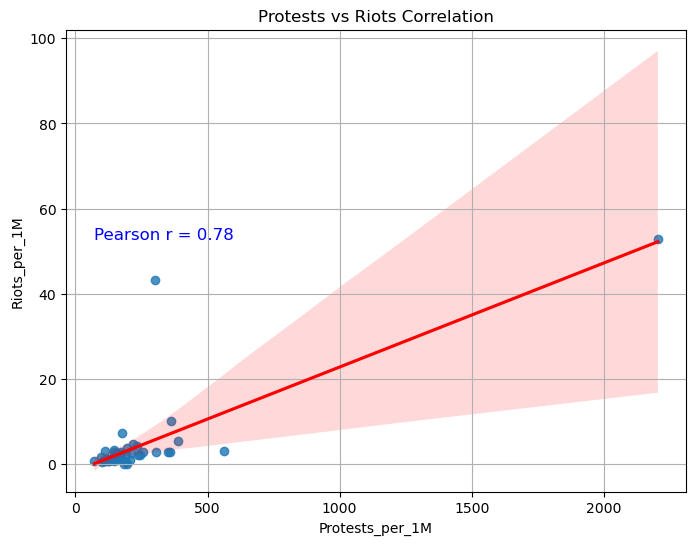

In [31]:
corr1, pval1 = pearsonr(x, y)
print(f"[Plot 1] Protests vs Riots: Pearson r = {corr1:.2f}, p-value = {pval1:.15f}")

plt.figure(figsize=(8,6))
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.text(x.min(), y.max(), f"Pearson r = {corr1:.2f}", fontsize=12, color="blue")

plt.xlabel("Protests_per_1M")
plt.ylabel("Riots_per_1M")
plt.title("Protests vs Riots Correlation")
plt.grid(True)
plt.show()

[Plot 2] Protests vs Violence: Pearson r = 0.89, p-value = 0.00000000000000000142


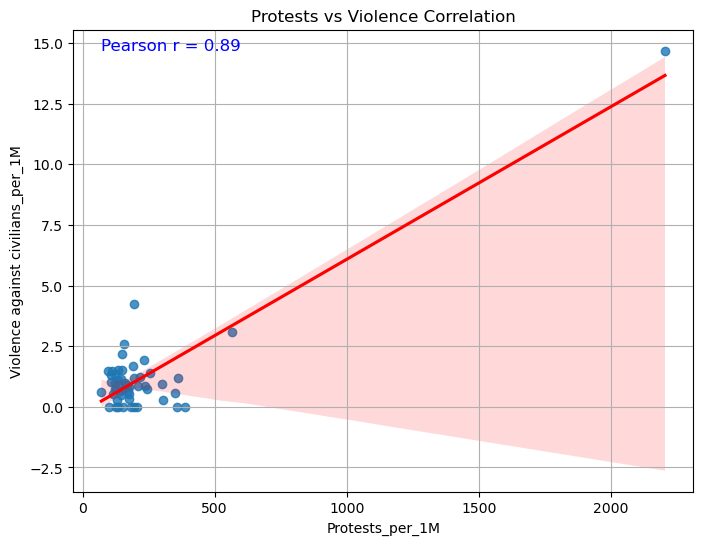

In [33]:
corr2, pval2 = pearsonr(x, z)
print(f"[Plot 2] Protests vs Violence: Pearson r = {corr2:.2f}, p-value = {pval2:.20f}")

plt.figure(figsize=(8,6))
sns.regplot(x=x, y=z, line_kws={"color": "red"})
plt.text(x.min(), z.max(), f"Pearson r = {corr2:.2f}", fontsize=12, color="blue")

plt.xlabel("Protests_per_1M")
plt.ylabel("Violence against civilians_per_1M")
plt.title("Protests vs Violence Correlation")
plt.grid(True)
plt.show()


[Plot 3] Riots vs Violence: Pearson r = 0.71, p-value = 0.000000005391729


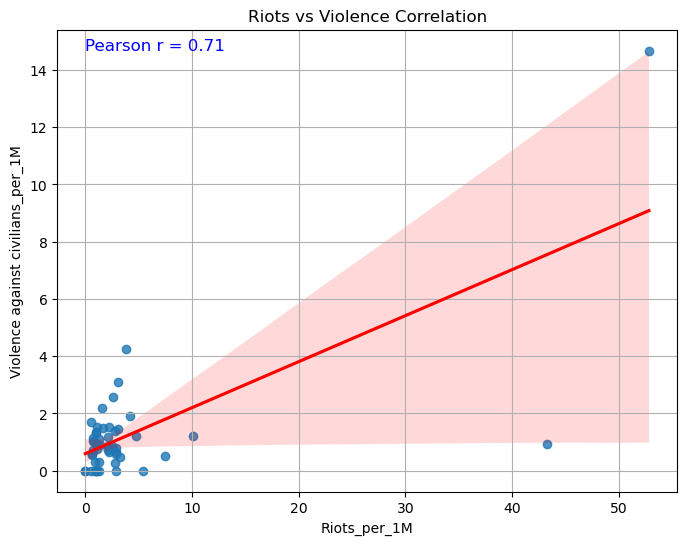

In [35]:
corr3, pval3 = pearsonr(y, z)
print(f"[Plot 3] Riots vs Violence: Pearson r = {corr3:.2f}, p-value = {pval3:.15f}")

plt.figure(figsize=(8,6))
sns.regplot(x=y, y=z, line_kws={"color": "red"})
plt.text(y.min(), z.max(), f"Pearson r = {corr3:.2f}", fontsize=12, color="blue")

plt.xlabel("Riots_per_1M")
plt.ylabel("Violence against civilians_per_1M")
plt.title("Riots vs Violence Correlation")
plt.grid(True)
plt.show()

## ELBOW METHOD AND K-MEANS CLUSTERING

In [38]:
X_scaled = StandardScaler().fit_transform(X)

In [40]:
#Elbow
inertias = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

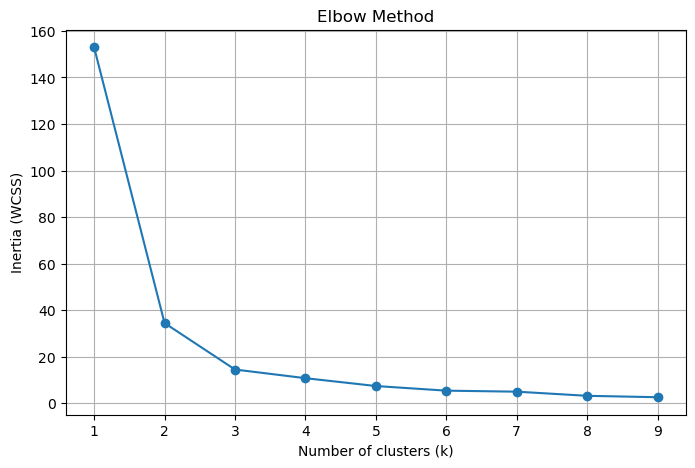

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [44]:
# Silhouette Score
scores = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores[k] = score
    print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=2: 0.9073
Silhouette Score for k=3: 0.8235
Silhouette Score for k=4: 0.4589
Silhouette Score for k=5: 0.3263
Silhouette Score for k=6: 0.3010
Silhouette Score for k=7: 0.2748
Silhouette Score for k=8: 0.3235
Silhouette Score for k=9: 0.3385


In [46]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged['Cluster'] = kmeans.fit_predict(X_scaled)
merged['Cluster'] = merged['Cluster'].astype(str)

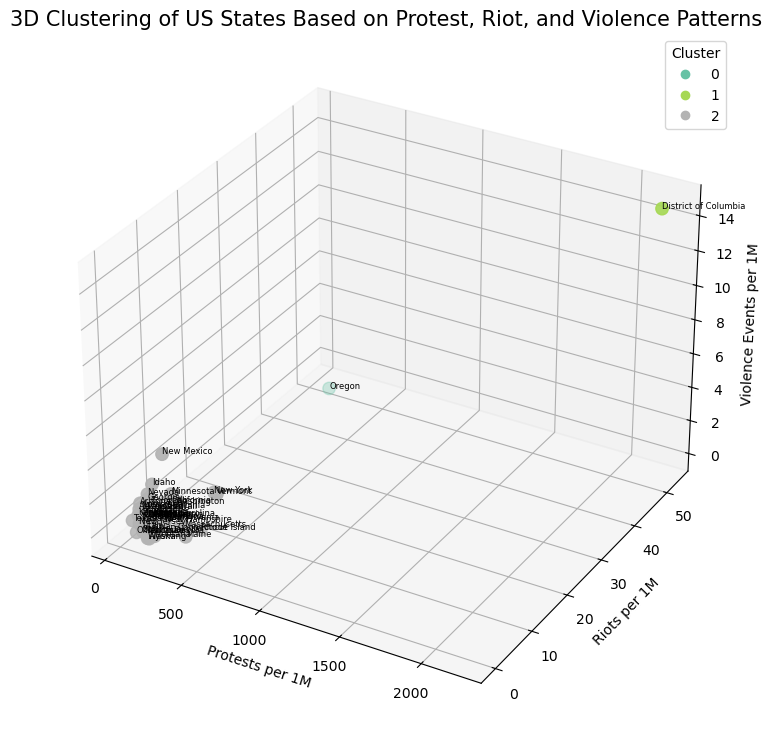

In [48]:
# Create 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    merged['Protests_per_1M'],
    merged['Riots_per_1M'],
    merged['Violence against civilians_per_1M'],
    c=merged['Cluster'].astype(int),
    cmap='Set2',
    s=80  # Size of points
)

# Add & set labels
for i, row in merged.iterrows():
    ax.text(row['Protests_per_1M'], row['Riots_per_1M'], row['Violence against civilians_per_1M'], row['State'], size=6)
    
ax.set_xlabel('Protests per 1M')
ax.set_ylabel('Riots per 1M')
ax.set_zlabel('Violence Events per 1M')

ax.set_title('3D Clustering of US States Based on Protest, Riot, and Violence Patterns', fontsize=15)

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


In [49]:
for cluster_id in sorted(merged['Cluster'].unique()):
    print(f" Cluster {cluster_id} (sorted by Protests_per_1M, descending):")
    cluster_data = merged[merged['Cluster'] == cluster_id].sort_values(by='Protests_per_1M', ascending=False)
    display(cluster_data[['State', 'Protests_per_1M', 'Riots_per_1M', 'Violence against civilians_per_1M']])


 Cluster 0 (sorted by Protests_per_1M, descending):


State  Protests_per_1M  Riots_per_1M  Violence against civilians_per_1M
37  Oregon       300.402582      43.25045                           0.940227

 Cluster 1 (sorted by Protests_per_1M, descending):


State  Protests_per_1M  Riots_per_1M  \
8  District of Columbia      2204.626957     52.840593   

   Violence against civilians_per_1M  
8                          14.677942

 Cluster 2 (sorted by Protests_per_1M, descending):


State  Protests_per_1M  Riots_per_1M  \
45         Vermont       564.049785      3.090684   
39    Rhode Island       389.362083      5.445624   
32        New York       361.065352     10.074368   
19           Maine       357.395978      2.882226   
21   Massachusetts       349.940442      2.839273   
6      Connecticut       305.696629      2.758995   
11          Hawaii       256.705728      2.767717   
29   New Hampshire       244.467507      2.150741   
38    Pennsylvania       236.123062      2.150763   
23       Minnesota       232.775201      4.181590   
4       California       217.448970      4.759798   
49       Wisconsin       211.162799      2.535982   
26         Montana       205.931471      0.895354   
31      New Mexico       196.203704      3.773148   
1           Alaska       194.371544      0.000000   
13        Illinois       192.834962      2.126856   
48   West Virginia       189.499160      0.562312   
50         Wyoming       183.723789      0.000000   
47      Washington       175.662641      7.420563   
15            Iowa       175.050877      1.245914   
46        Virginia       173.919760      2.871859   
20        Maryland       172.252326      2.255877   
22        Michigan       168.490004      1.389199   
7         Delaware       158.638296      0.979249   
33  North Carolina       157.310137      2.609410   
12           Idaho       155.098026      2.584967   
34    North Dakota       152.897367      1.274145   
28          Nevada       150.724855      1.570051   
5         Colorado       148.067622      2.217603   
17        Kentucky       146.202048      2.866707   
42       Tennessee       144.628447      0.707576   
25        Missouri       144.384341      3.230075   
18       Louisiana       134.433258      1.084139   
9          Florida       133.966356      1.293714   
27        Nebraska       133.926329      1.010765   
35            Ohio       132.342196      1.100735   
44            Utah       129.114713      0.884347   
14         Indiana       125.089931      0.729813   
41    South Dakota       124.527869      1.102017   
24     Mississippi       122.845946      1.018060   
0          Alabama       122.278021      0.786354   
40  South Carolina       120.840815      1.132883   
30      New Jersey       115.905598      0.642136   
10         Georgia       111.878779      3.016340   
16          Kansas       109.256688      0.678613   
3         Arkansas       108.874327      0.983804   
36        Oklahoma        99.041079      0.496447   
2          Arizona        97.440817      1.626272   
43           Texas        70.921220      0.629380   

    Violence against civilians_per_1M  
45                           3.090684  
39                           0.000000  
32                           1.208924  
19                           0.000000  
21                           0.567855  
6                            0.275899  
11                           1.383858  
29                           0.716914  
38                           0.844943  
23                           1.916562  
4                            1.221766  
49                           0.845327  
26                           0.000000  
31                           4.244792  
1                            0.000000  
13                           1.181587  
48                           1.686936  
50                           0.000000  
47                           0.511763  
15                           0.311478  
46                           0.804120  
20                           0.644536  
22                           0.893057  
7                            0.979249  
33                           0.745546  
12                           2.584967  
34                           0.000000  
28                           2.198071  
5                            1.535263  
17                           0.661548  
42                           1.132121  
25                           0.484511  
18                           1.517795  
9 

In [50]:
# Cluster profiles
cluster_summary = merged.groupby('Cluster')[
    ['Protests_per_1M', 'Riots_per_1M', 'Violence against civilians_per_1M']
].mean().round(2)

print(cluster_summary)

         Protests_per_1M  Riots_per_1M  Violence against civilians_per_1M
Cluster                                                                  
0                 300.40         43.25                               0.94
1                2204.63         52.84                              14.68
2                 185.81          2.13                               0.95


In [51]:
# Count number of states per cluster
state_counts = merged['Cluster'].value_counts().sort_index()
print(state_counts)


Cluster
0     1
1     1
2    49
Name: count, dtype: int64


## EXCLUDING 2 OUTLIERS

In [57]:
merged2 = merged[~merged['State'].isin(['Oregon', 'District of Columbia'])]
merged2 = merged2.copy()

In [59]:
features2 = ['Protests_per_1M', 'Riots_per_1M', 'Violence against civilians_per_1M']
X2 = merged2[features2]
X_scaled2 = StandardScaler().fit_transform(X2)

## ELBOW METHOD AND K-MEANS CLUSTERING (after excluding 2 outliers)

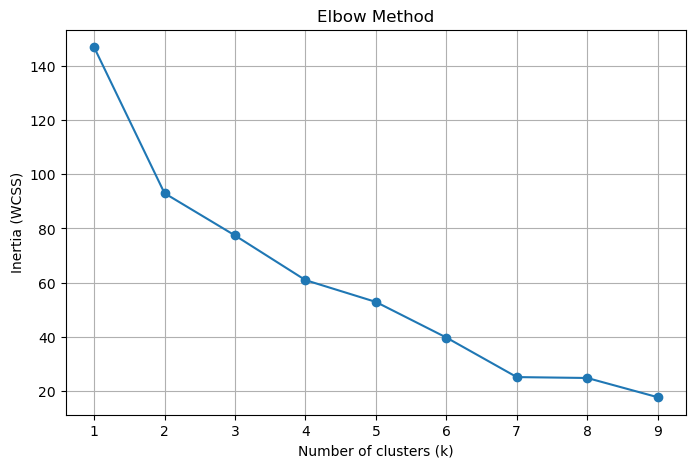

In [62]:
inertias = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled2)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


In [64]:
# Silhouette Score after excluding 2 outliers
scores = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled2)
    score = silhouette_score(X_scaled2, labels)
    scores[k] = score
    print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=2: 0.4744
Silhouette Score for k=3: 0.2795
Silhouette Score for k=4: 0.2951
Silhouette Score for k=5: 0.2882
Silhouette Score for k=6: 0.3255
Silhouette Score for k=7: 0.3450
Silhouette Score for k=8: 0.2909
Silhouette Score for k=9: 0.3498


In [66]:
# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
merged2['Cluster'] = kmeans.fit_predict(X_scaled2)
merged2['Cluster'] = merged2['Cluster'].astype(str)

In [68]:
# 3D Plot ( after excluding 2 outliers)
cluster_color_map = {
    '0': '#fc8d62',  # greenish (Cluster 0)
    '1': '#65c2a5'   # orangish (Cluster 1)
}

merged2['Color'] = merged2['Cluster'].map(cluster_color_map)

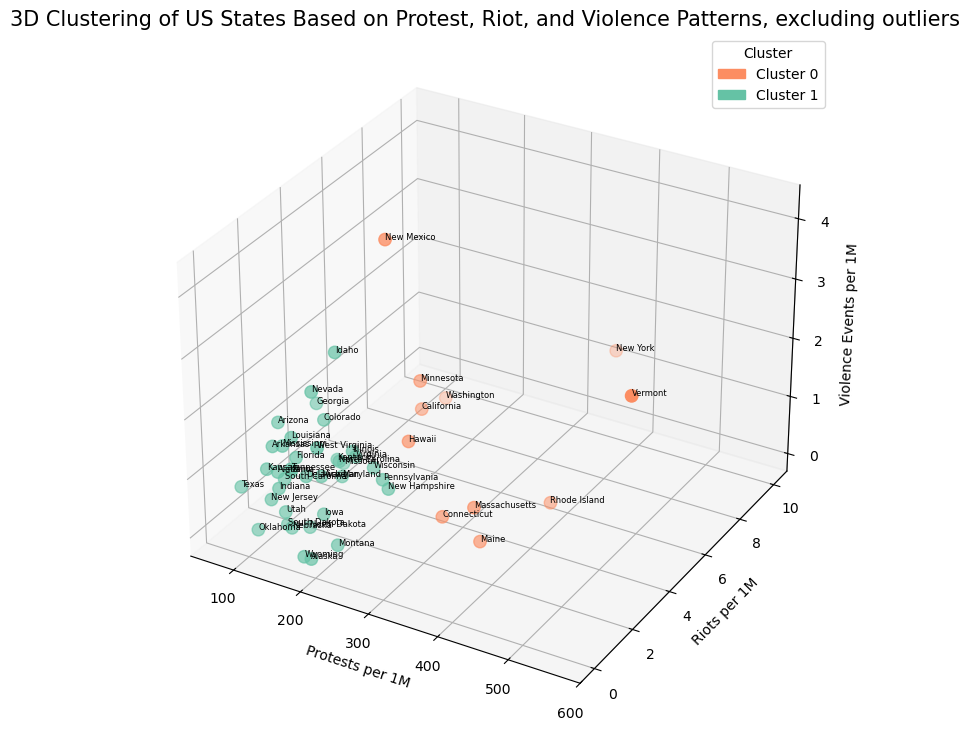

In [70]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Scatter with custom colors
scatter = ax.scatter(
    merged2['Protests_per_1M'],
    merged2['Riots_per_1M'],
    merged2['Violence against civilians_per_1M'],
    c=merged2['Color'],
    s=80)

# Add Labels
for i, row in merged2.iterrows():
    ax.text(
        row['Protests_per_1M'],
        row['Riots_per_1M'],
        row['Violence against civilians_per_1M'],
        row['State'],
        size=6)

# Set Axis Labels
ax.set_xlabel('Protests per 1M')
ax.set_ylabel('Riots per 1M')
ax.set_zlabel('Violence Events per 1M')
ax.set_title('3D Clustering of US States Based on Protest, Riot, and Violence Patterns, excluding outliers', fontsize=15)

# Custom Manual Legend

legend_elements = [
    mpatches.Patch(color='#fc8d62', label='Cluster 0'),
    mpatches.Patch(color='#65c2a5', label='Cluster 1')]
ax.legend(handles=legend_elements, title='Cluster')

plt.show()

## States by Cluster, Ranked by Protests per 1M (after excluding 2 outliers)


In [73]:
# Cluster profiles
cluster_summary2 = merged2.groupby('Cluster')[
    ['Protests_per_1M', 'Riots_per_1M', 'Violence against civilians_per_1M']
].mean().round(2)

print(cluster_summary2)

         Protests_per_1M  Riots_per_1M  Violence against civilians_per_1M
Cluster                                                                  
0                 309.66          4.54                               1.31
1                 149.96          1.43                               0.85


In [75]:
# Count number of states per cluster
state_counts2 = merged2['Cluster'].value_counts().sort_index()
print(state_counts2)


Cluster
0    11
1    38
Name: count, dtype: int64


In [77]:
for cluster_id in sorted(merged2['Cluster'].unique()):
    print(f" Cluster {cluster_id} (sorted by Protests_per_1M, descending):")
    cluster_data = merged2[merged2['Cluster'] == cluster_id].sort_values(by='Protests_per_1M', ascending=False)
    display(cluster_data[['State', 'Protests_per_1M', 'Riots_per_1M', 'Violence against civilians_per_1M']])

 Cluster 0 (sorted by Protests_per_1M, descending):


State  Protests_per_1M  Riots_per_1M  \
45        Vermont       564.049785      3.090684   
39   Rhode Island       389.362083      5.445624   
32       New York       361.065352     10.074368   
19          Maine       357.395978      2.882226   
21  Massachusetts       349.940442      2.839273   
6     Connecticut       305.696629      2.758995   
11         Hawaii       256.705728      2.767717   
23      Minnesota       232.775201      4.181590   
4      California       217.448970      4.759798   
31     New Mexico       196.203704      3.773148   
47     Washington       175.662641      7.420563   

    Violence against civilians_per_1M  
45                           3.090684  
39                           0.000000  
32                           1.208924  
19                           0.000000  
21                           0.567855  
6                            0.275899  
11                           1.383858  
23                           1.916562  
4                            1.221766  
31                           4.244792  
47                           0.511763

 Cluster 1 (sorted by Protests_per_1M, descending):


State  Protests_per_1M  Riots_per_1M  \
29   New Hampshire       244.467507      2.150741   
38    Pennsylvania       236.123062      2.150763   
49       Wisconsin       211.162799      2.535982   
26         Montana       205.931471      0.895354   
1           Alaska       194.371544      0.000000   
13        Illinois       192.834962      2.126856   
48   West Virginia       189.499160      0.562312   
50         Wyoming       183.723789      0.000000   
15            Iowa       175.050877      1.245914   
46        Virginia       173.919760      2.871859   
20        Maryland       172.252326      2.255877   
22        Michigan       168.490004      1.389199   
7         Delaware       158.638296      0.979249   
33  North Carolina       157.310137      2.609410   
12           Idaho       155.098026      2.584967   
34    North Dakota       152.897367      1.274145   
28          Nevada       150.724855      1.570051   
5         Colorado       148.067622      2.217603   
17        Kentucky       146.202048      2.866707   
42       Tennessee       144.628447      0.707576   
25        Missouri       144.384341      3.230075   
18       Louisiana       134.433258      1.084139   
9          Florida       133.966356      1.293714   
27        Nebraska       133.926329      1.010765   
35            Ohio       132.342196      1.100735   
44            Utah       129.114713      0.884347   
14         Indiana       125.089931      0.729813   
41    South Dakota       124.527869      1.102017   
24     Mississippi       122.845946      1.018060   
0          Alabama       122.278021      0.786354   
40  South Carolina       120.840815      1.132883   
30      New Jersey       115.905598      0.642136   
10         Georgia       111.878779      3.016340   
16          Kansas       109.256688      0.678613   
3         Arkansas       108.874327      0.983804   
36        Oklahoma        99.041079      0.496447   
2          Arizona        97.440817      1.626272   
43           Texas        70.921220      0.629380   

    Violence against civilians_per_1M  
29                           0.716914  
38                           0.844943  
49                           0.845327  
26                           0.000000  
1                            0.000000  
13                           1.181587  
48                           1.686936  
50                           0.000000  
15                           0.311478  
46                           0.804120  
20                           0.644536  
22                           0.893057  
7                            0.979249  
33                           0.745546  
12                           2.584967  
34                           0.000000  
28                           2.198071  
5                            1.535263  
17                           0.661548  
42                           1.132121  
25                           0.484511  
18                           1.517795  
9                            1.115271  
27                           0.000000  
35                           0.931391  
44                           0.294782  
14                           0.729813  
41                           0.000000  
24                           1.357414  
0                            0.982942  
40                           0.755255  
30                           0.535114  
10                           1.462468  
16                           1.017919  
3                            1.311739  
36                           0.000000  
2                            1.490750  
43                           0.596255

## MAP

In [80]:
# Convert State names to 2-letter codes (including D.C.)
def state_to_code(state):
    if state == 'District of Columbia':
        return 'DC'
    match = us.states.lookup(state)
    return match.abbr if match else None

merged2['State_code'] = merged2['State'].map(state_to_code)
merged['State_code'] = merged['State'].map(state_to_code)

In [82]:
# Create the Choropleth map
fig = px.choropleth(
    merged2,
    locations='State_code',
    locationmode="USA-states",
    color='Cluster',
    scope="usa",
    color_discrete_sequence=px.colors.qualitative.Set2
)

In [83]:
#Add 2-letter state codes on the map
state_coords = {
    'AL': [32.8, -86.8], 'AK': [61.4, -152.4], 'AZ': [33.7, -111.4], 'AR': [34.9, -92.4],
    'CA': [36.1, -119.7], 'CO': [39.1, -105.3], 'CT': [41.6, -72.8], 'DE': [39.3, -75.5],
    'DC': [38.9, -77.0], 'FL': [27.8, -81.7], 'GA': [33.0, -83.6], 'HI': [21.1, -157.5],
    'ID': [44.2, -114.5], 'IL': [40.3, -89.0], 'IN': [39.8, -86.3], 'IA': [42.0, -93.2],
    'KS': [38.5, -96.7], 'KY': [37.7, -84.7], 'LA': [31.2, -91.9], 'ME': [44.7, -69.4],
    'MD': [39.1, -76.8], 'MA': [42.2, -71.5], 'MI': [43.3, -84.5], 'MN': [45.7, -93.9],
    'MS': [32.7, -89.7], 'MO': [38.5, -92.3], 'MT': [46.9, -110.5], 'NE': [41.1, -98.3],
    'NV': [38.3, -117.1], 'NH': [43.5, -71.6], 'NJ': [40.3, -74.5], 'NM': [34.8, -106.2],
    'NY': [42.2, -74.9], 'NC': [35.6, -79.8], 'ND': [47.5, -99.8], 'OH': [40.4, -82.8],
    'OK': [35.6, -96.9], 'OR': [44.6, -122.1], 'PA': [40.6, -77.2], 'RI': [41.7, -71.5],
    'SC': [33.9, -80.9], 'SD': [44.3, -99.4], 'TN': [35.7, -86.7], 'TX': [31.1, -97.6],
    'UT': [40.2, -111.9], 'VT': [44.0, -72.7], 'VA': [37.8, -78.2], 'WA': [47.4, -121.5],
    'WV': [38.5, -81.0], 'WI': [44.3, -89.6], 'WY': [42.8, -107.3]
}

In [84]:
# Separate lats/lons/texts
state_codes = list(state_coords.keys())
lats = [state_coords[code][0] for code in state_codes]
lons = [state_coords[code][1] for code in state_codes]
texts = [code if code in merged['State_code'].values else '' for code in state_codes]

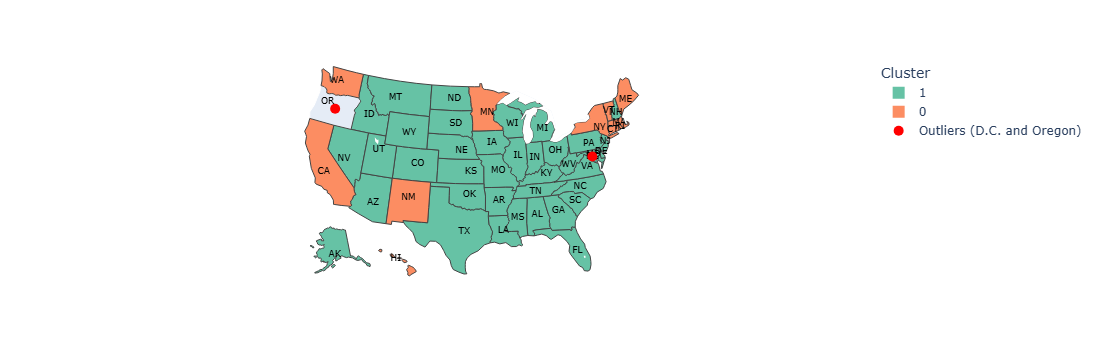

In [88]:
# Add 2-letter codes (small black text)
fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=lons,
    lat=lats,
    text=texts,
    mode='text',
    textfont=dict(size=9, color='black'),
    showlegend=False
))

#ADD Outliers: District of Columbia and Oregon manually 
outliers = {
    'District of Columbia': {'lat': 38.91, 'lon': -77.04},
    'Oregon': {'lat': 44.0, 'lon': -120.5}
}

fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=[outliers['District of Columbia']['lon'], outliers['Oregon']['lon']],
    lat=[outliers['District of Columbia']['lat'], outliers['Oregon']['lat']],
    mode='markers+text',
    marker=dict(size=10, color='red', symbol='circle'),
    name='Outliers (D.C. and Oregon)'
))

fig.update_layout(legend_title_text='Cluster')

fig.show()


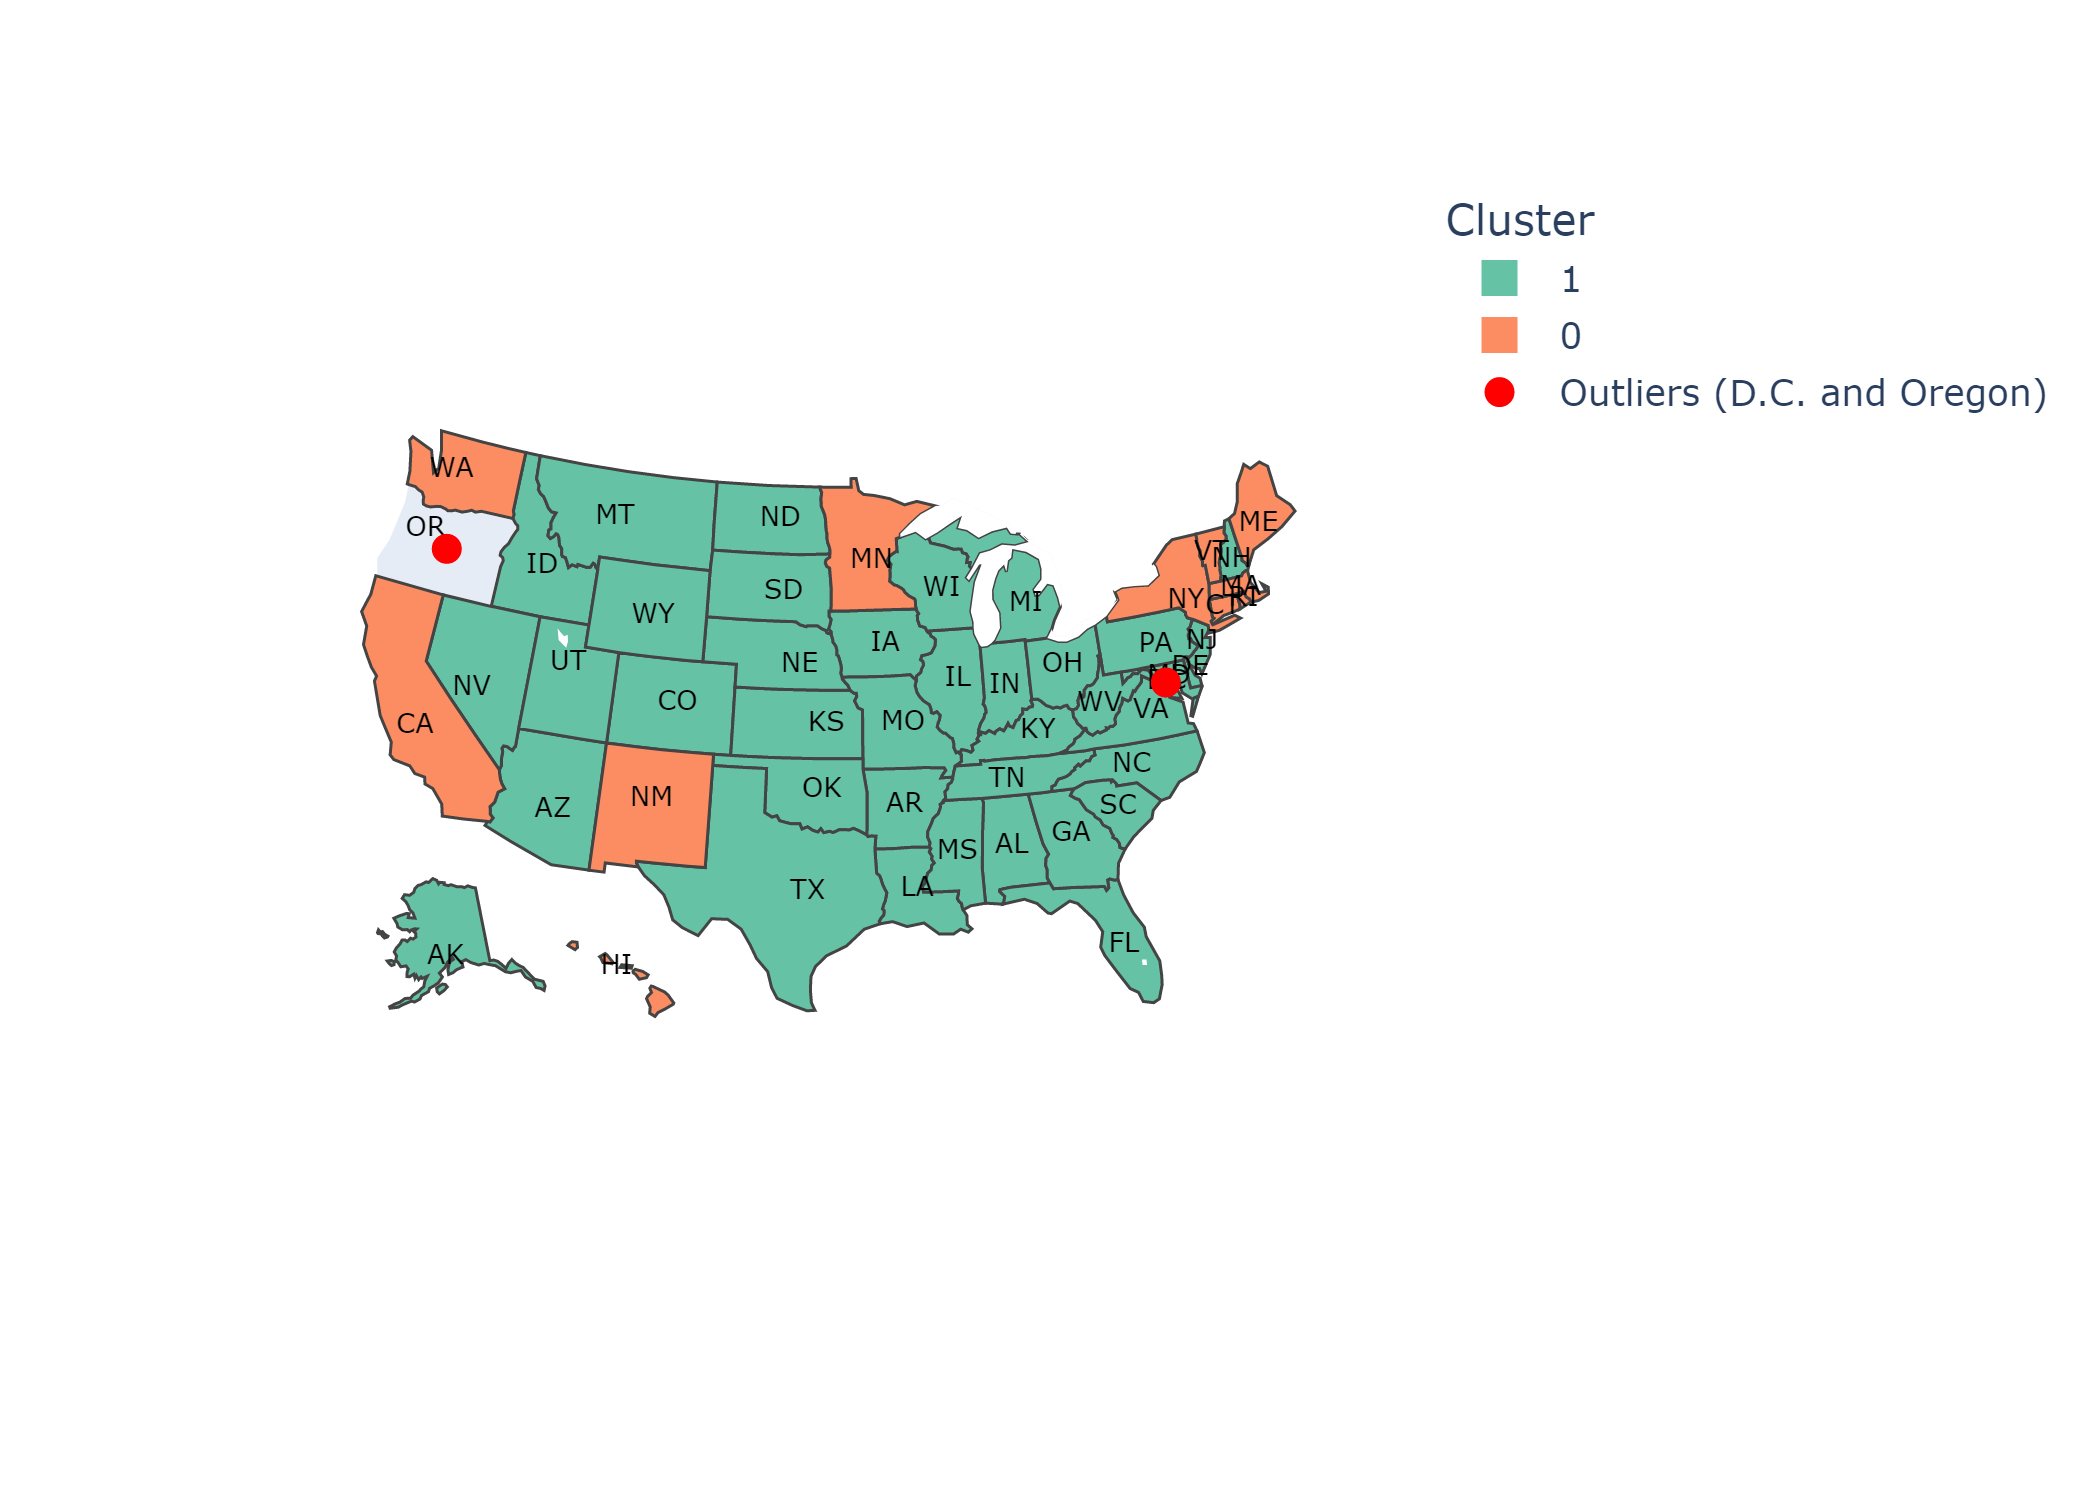

In [90]:
from IPython.display import Image
Image(filename='us_states_clusters6.png')